In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
import numpy as np

In [ ]:
ROWS=224
COLS=224
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input)
train_gen = train_idg.flow_from_directory(
    '../input/datatask2/task2/train',
    target_size=(ROWS, COLS),
    batch_size = 64,
    shuffle=True
)
val_datagen = ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_directory(
    '../input/datatask2/task2/val',
    target_size=(ROWS, COLS),
    batch_size = 16
)

In [ ]:
train_gen.class_indices

In [ ]:
class_weights={0:2.0657,1:0.536,2:1.53448}

In [ ]:

input_shape = (ROWS, COLS, 3)
nclass = len(train_gen.class_indices)

base_model = tf.keras.applications.ResNet152V2(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
'''for layers in base_model.layers:
    if layers.name.find('bn')!=-1:
        layers.trainable=True
    else:
        layers.trainable=False'''

base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
'''add_model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
add_model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
'''
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(),
              metrics=metrics)
model.summary()
import tensorflow.keras as keras

In [ ]:
file_path="weights.best.hdf5"

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss-xception.h5', monitor='loss', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss-xception.h5', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [es, mc,ms] #early


history = model.fit(train_gen,
                              validation_data=val_gen, 
                              epochs=100, 
                              shuffle=True, 
                              verbose=True,
                                class_weight=class_weights,
                              callbacks=callbacks_list)

In [ ]:
savemodel = tf.keras.models.load_model('best_model_alt-valloss-xception.h5')

In [15]:
import os
predicted=[]
real=[]
for dir in os.listdir("../input/datatask2/task2/test"):
    if dir=='humanitarian':
        r=0
    elif dir =='non_informative':
        r=1
    else:
        r=2
    for path in os.listdir(f'../input/datatask2/task2/test/{dir}'):
        p=f'../input/datatask2/task2/test/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(224, 224)
)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        img_array=preprocess_input(img_array)

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))
for dir in os.listdir("../input/datatask2/task2/val"):
    if dir=='humanitarian':
        r=0
    elif dir =='non_informative':
        r=1
    else:
        r=2
    for path in os.listdir(f'../input/datatask2/task2/val/{dir}'):
        p=f'../input/datatask2/task2/val/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(224, 224)
)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        img_array=preprocess_input(img_array)

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [16]:
from sklearn import metrics
print(metrics.classification_report(real,predicted))
print(metrics.confusion_matrix(real,predicted))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63       583
           1       0.93      0.80      0.86      2248
           2       0.68      0.86      0.76       786

    accuracy                           0.79      3617
   macro avg       0.73      0.78      0.75      3617
weighted avg       0.82      0.79      0.80      3617

[[ 400   97   86]
 [ 221 1792  235]
 [  69   39  678]]


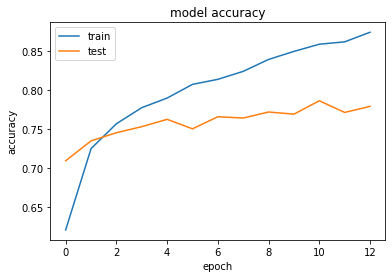

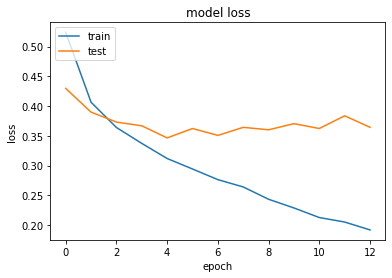

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

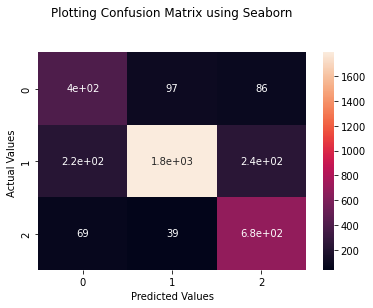

In [19]:
conf_matrix = (confusion_matrix(real, predicted))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True)

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

# labels the boxes
